In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pickle
import string
import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from nltk.corpus import stopwords

%matplotlib inline

In [2]:
nlp = spacy.load('en')

In [3]:
cleaned_articles_dict = pickle.load(open("cleaned_articles_dict.pkl", "rb"))
len(cleaned_articles_dict)

251328

In [4]:
# extract only articles
articles = [article["article"] for article in cleaned_articles_dict]

In [5]:
def run_lemma(article):
    """
    Lemmatize article.
    article should be a single string of text
    """
    remain = ''
    doc = nlp(article.lower())
    for token in doc:
        if token.is_stop:
            continue
        elif token.is_space:
            continue
        elif len(token)<=1:
            continue
        elif str(token) == "cnn":
            continue
        else:
            remain += token.lemma_ + ' '
    return remain

In [ ]:
# lemmatize articles
clean_articles = [run_lemma(article) for article in articles]
len(clean_articles)

In [58]:
# pickle for future use
pickle.dump(clean_articles,open("articles_lemma_lda.pkl","wb"))

In [7]:
cleaned_articles = pickle.load(open("articles_lemma_lda.pkl", "rb"))
len(cleaned_articles)

251328

In [8]:
# remove irrelevant terms
recleaned_articles = [re.sub("say", "", article).strip() for article in cleaned_articles]
recleaned_articles = [re.sub("year", "", article).strip() for article in recleaned_articles]
recleaned_articles = [re.sub("time", "", article).strip() for article in recleaned_articles]
recleaned_articles = [re.sub("EST", "", article).strip() for article in recleaned_articles]
recleaned_articles = [re.sub("est", "", article).strip() for article in recleaned_articles]
recleaned_articles = [re.sub("[Dd]aily [Mm]ail", "", article).strip() for article in recleaned_articles]

### Topic Modeling

In [9]:
# vectorize cleaned articles
cv = CountVectorizer(min_df=20)
X_articles = cv.fit_transform(recleaned_articles)
word_list = cv.get_feature_names()
len(word_list)

37980

In [10]:
# identify latent topics using latent Dirichlet allocation (LDA)
lda = LatentDirichletAllocation(n_components=20, max_iter=15, learning_method='online', learning_offset=50.,random_state=916)
X_reduced = lda.fit_transform(X_articles)
components = lda.components_
print(lda.components_)

[[ 0.05        0.05        0.05       ...,  0.05        0.05        0.05      ]
 [ 0.05        0.05        0.05       ...,  0.05        0.05        0.05      ]
 [ 0.05000002  0.05        0.05       ...,  0.05        0.05        0.05      ]
 ..., 
 [ 0.05        0.05000001  0.05       ...,  0.05        0.05        0.05      ]
 [ 0.05        0.05        0.05       ...,  0.05        0.05        0.05      ]
 [ 0.05        0.05000001  0.05       ...,  0.05        0.05        0.05      ]]


In [11]:
X_reduced.shape

(251328, 20)

In [12]:
components.shape

(20, 37980)

In [13]:
# examine the top 20 words associated with each latent topic
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(word_list, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:20],"\n")

topic 0
[('new', 31440.425513934399), ('video', 23059.799617243836), ('look', 19991.99325787335), ('image', 19749.726874290027), ('like', 19317.39407629085), ('post', 18816.816812895217), ('picture', 18535.315717576024), ('facebook', 17948.862959994731), ('photo', 16245.063833528084), ('create', 15645.876016930346), ('work', 14713.031033668689), ('people', 14695.042932056491), ('design', 14445.37991069525), ('model', 14159.220806261454), ('user', 13910.143486594696), ('online', 13320.215319617228), ('world', 12765.084431320052), ('twitter', 12660.539567475615), ('scroll', 12607.408380911515), ('show', 12201.664472035944)] 

topic 1
[('russian', 8730.0105678476193), ('russia', 6761.1630239901724), ('prot', 6479.7448348956432), ('people', 5987.6352581462179), ('city', 5839.1455432427319), ('india', 5578.9218009844717), ('german', 5022.2607898329743), ('government', 4601.6281136164607), ('japan', 4586.3721629253669), ('country', 4540.0893238868357), ('indian', 4207.6884915315077), ('presi

topic 13
[('child', 63985.449922156673), ('school', 49136.597142767554), ('old', 37837.603949187316), ('mother', 34385.09263713198), ('girl', 30021.017763181844), ('family', 29125.895248280704), ('student', 26918.839000504031), ('boy', 25824.29566748616), ('parent', 24522.481716021965), ('father', 23413.980323381646), ('son', 23322.268123010283), ('young', 23169.921402985205), ('daughter', 22117.488094985638), ('university', 14510.427605078536), ('tell', 14203.065000211718), ('teacher', 11497.627271496785), ('age', 11328.143094462608), ('baby', 10578.271915528836), ('home', 10327.588892994156), ('high', 9171.6638995747471)] 

topic 14
[('claim', 22524.193029115657), ('report', 20656.539235275748), ('law', 14089.393182443921), ('ban', 12546.383584833771), ('rule', 11368.872622403504), ('official', 11201.193436595491), ('statement', 10624.793308836975), ('invigation', 10407.521664453712), ('case', 10009.034229770978), ('file', 9913.3226966960992), ('public', 9369.1533683703419), ('tell',

### Unsupervised Clustering

In [14]:
# try out a range of cluster sizes to find the one with the best inertia and silhouette scores
ns = np.arange(2, 21, 1)
inertias = []
silhouettes = []

for n in ns:
    kmeans = KMeans(n_clusters=n, init="k-means++", random_state=8888)
    kmeans.fit(X_reduced)
    inertias.append(kmeans.inertia_)
    labels = kmeans.labels_
    # only a sample was used to calculate silhouette score because of memory errors
    silhouettes.append(silhouette_score(X_reduced, labels, metric='euclidean', sample_size=10000))

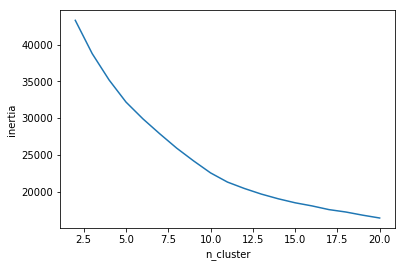

In [15]:
# plot the inertia scores
plt.plot(ns, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

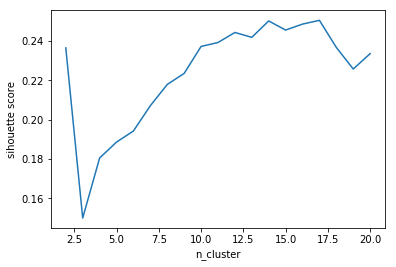

In [16]:
# plot the silhouettte scores
plt.plot(ns, silhouettes)
plt.xlabel('n_cluster')
plt.ylabel('sihouette score');

In [18]:
# based on inertia and silhouette scores, a cluster size of 11 was selected
kmeans = KMeans(n_clusters=11, init="k-means++", random_state=8888)
kmeans.fit(X_reduced)
cluster_labels = kmeans.labels_
print(kmeans.inertia_)
print(silhouette_score(X_reduced, cluster_labels, metric='euclidean', sample_size=5000))

21302.3597181
0.245475721455


In [19]:
# examine the number of reviews for in each cluster
for cluster in range(len(set(cluster_labels))):
    print("Cluster {} has {} reviews.".format(cluster, sum(cluster_labels==cluster)))

Cluster 0 has 27760 reviews.
Cluster 1 has 19038 reviews.
Cluster 2 has 21917 reviews.
Cluster 3 has 19978 reviews.
Cluster 4 has 13618 reviews.
Cluster 5 has 19292 reviews.
Cluster 6 has 28892 reviews.
Cluster 7 has 14276 reviews.
Cluster 8 has 23706 reviews.
Cluster 9 has 34562 reviews.
Cluster 10 has 28289 reviews.


In [20]:
# add cluster label to dict
index = 0
for article_dict in cleaned_articles_dict:
    article_dict["cluster"] = (cluster_labels[index])
    index += 1

In [ ]:
# pickle for future use
pickle.dump(cleaned_articles_dict,open("clustered_articles_dict.pkl","wb"))

After topic modeling and unsupervised clustering, I identified clusters of articles associated with crime, technology and science, soccer, business, culture and celebrities, terrorism and military, and sports.